In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import tensorflow as tf

from keras.layers.advanced_activations import LeakyReLU, PReLU
from math import cos, sin, pi
from PIL import Image
from tqdm import tqdm
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data load & train/test split

In [3]:
# 경로 이동
os.chdir('/content/drive/MyDrive/dacon_keypoint_data')

In [4]:
root_dir = '/content/drive/MyDrive/dacon_keypoint_data'

In [5]:
train_all = glob.glob('train_imgs/*.jpg')
len(train_all)

4195

In [6]:
train_all[:5]

['train_imgs/546-1-2-25-Z134_C-0000005.jpg',
 'train_imgs/546-1-2-25-Z134_C-0000017.jpg',
 'train_imgs/546-1-2-25-Z134_C-0000021.jpg',
 'train_imgs/546-1-2-25-Z134_D-0000007.jpg',
 'train_imgs/546-1-2-25-Z134_D-0000021.jpg']

In [7]:
# validation용 파일은 10% 비율로 random sampling
random.seed(1)
src = "train_imgs"
all_filename = os.listdir(src)

valid_filename = random.sample(all_filename, int(len(train_all) * 0.1))
train_filename = [x for x in all_filename if x not in valid_filename]

In [8]:
print(len(train_filename), len(valid_filename))

3776 419


In [9]:
train_filename = [src+'/'+ name for name in train_filename]
valid_filename = [src+'/' + name for name in valid_filename]

In [10]:
print(train_filename[:5])
print(valid_filename[:5])

['train_imgs/546-1-2-25-Z134_C-0000005.jpg', 'train_imgs/546-1-2-25-Z134_C-0000017.jpg', 'train_imgs/546-1-2-25-Z134_C-0000021.jpg', 'train_imgs/546-1-2-25-Z134_D-0000007.jpg', 'train_imgs/546-1-2-25-Z134_D-0000021.jpg']
['train_imgs/329-2-1-16-Z57_A-0000019.jpg', 'train_imgs/594-1-3-28-Z134_E-0000029.jpg', 'train_imgs/194-2-1-09-Z36_D-0000003.jpg', 'train_imgs/642-2-4-31-Z148_D-0000001.jpg', 'train_imgs/001-1-1-01-Z17_E-0000009.jpg']


In [11]:
print('Total images: ', len(all_filename))
print('Training: ', len(train_filename))
print('Validation: ', len(valid_filename))

Total images:  4195
Training:  3776
Validation:  419


In [12]:
# # copy & paste images ('./train' 과 './val'에 복사 붙여넣기)
# for name in tqdm(train_filename):
#     shutil.copy(name, 'train')

# for name in tqdm(valid_filename):
#     shutil.copy(name, 'val')

In [13]:
# train, valid folder 속 모든 이미지 파일 read & sort
train_paths = glob.glob('./train/*.jpg')
valid_paths = glob.glob('./val/*.jpg')
train_paths.sort()
valid_paths.sort()

In [14]:
train_paths[:5]

['./train/001-1-1-01-Z17_A-0000001.jpg',
 './train/001-1-1-01-Z17_A-0000003.jpg',
 './train/001-1-1-01-Z17_A-0000005.jpg',
 './train/001-1-1-01-Z17_A-0000007.jpg',
 './train/001-1-1-01-Z17_A-0000009.jpg']

In [15]:
valid_paths[:5]

['./val/001-1-1-01-Z17_A-0000019.jpg',
 './val/001-1-1-01-Z17_A-0000021.jpg',
 './val/001-1-1-01-Z17_D-0000005.jpg',
 './val/001-1-1-01-Z17_D-0000019.jpg',
 './val/001-1-1-01-Z17_E-0000009.jpg']

In [16]:
train_filename_ = []
valid_filename_ = []

for t_paths in tqdm(train_paths):
    filename = t_paths.split('/')[-1]
    train_filename_.append(filename)

for v_paths in tqdm(valid_paths):
    filename = v_paths.split('/')[-1]
    valid_filename_.append(filename)

100%|██████████| 419/419 [00:00<00:00, 97363.62it/s]


In [17]:
print(train_filename_[:5])
print(valid_filename_[:5])

['001-1-1-01-Z17_A-0000001.jpg', '001-1-1-01-Z17_A-0000003.jpg', '001-1-1-01-Z17_A-0000005.jpg', '001-1-1-01-Z17_A-0000007.jpg', '001-1-1-01-Z17_A-0000009.jpg']
['001-1-1-01-Z17_A-0000019.jpg', '001-1-1-01-Z17_A-0000021.jpg', '001-1-1-01-Z17_D-0000005.jpg', '001-1-1-01-Z17_D-0000019.jpg', '001-1-1-01-Z17_E-0000009.jpg']


In [18]:
# train_df.csv
train = pd.read_csv('train_df.csv')

In [19]:
train.head(3)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.0,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.000000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,334.109461,1020.0,381.0,1083.0,389.0,984.0,362.0,1163.0,372.0,1027.507419,327.383120,1111.0,340.0,1016.0,552.0,1061.0,556.0,1018.0,674.0,1070.0,696.0,987.703151,788.867342,1044.0,826.0,1063.029716,358.679953,1042.374777,319.031541,1101.00000,334.0,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554


In [20]:
# 각각의 train, valid 이미지들의 정보만을 담고 있는 DataFrame 생성
train_df = train[train['image'].isin(train_filename_)]
train_df.reset_index(inplace=True, drop=True)

valid_df = train[train['image'].isin(valid_filename_)]
valid_df.reset_index(inplace=True, drop=True)

train_df.to_csv('train.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [21]:
# 최종 train, val, test
train = pd.read_csv('./train.csv')
valid = pd.read_csv('./valid.csv')

train_paths = glob.glob('./train/*.jpg')
valid_paths = glob.glob('./val/*.jpg')
test_paths = glob.glob('./test_imgs/*.jpg')
print(len(train_paths), len(valid_paths), len(test_paths))

train_paths.sort()
valid_paths.sort()
test_paths.sort()

train['path'] = train_paths
valid['path'] = valid_paths

3776 419 1600


In [22]:
train_paths[:3]

['./train/001-1-1-01-Z17_A-0000001.jpg',
 './train/001-1-1-01-Z17_A-0000003.jpg',
 './train/001-1-1-01-Z17_A-0000005.jpg']

#visualization

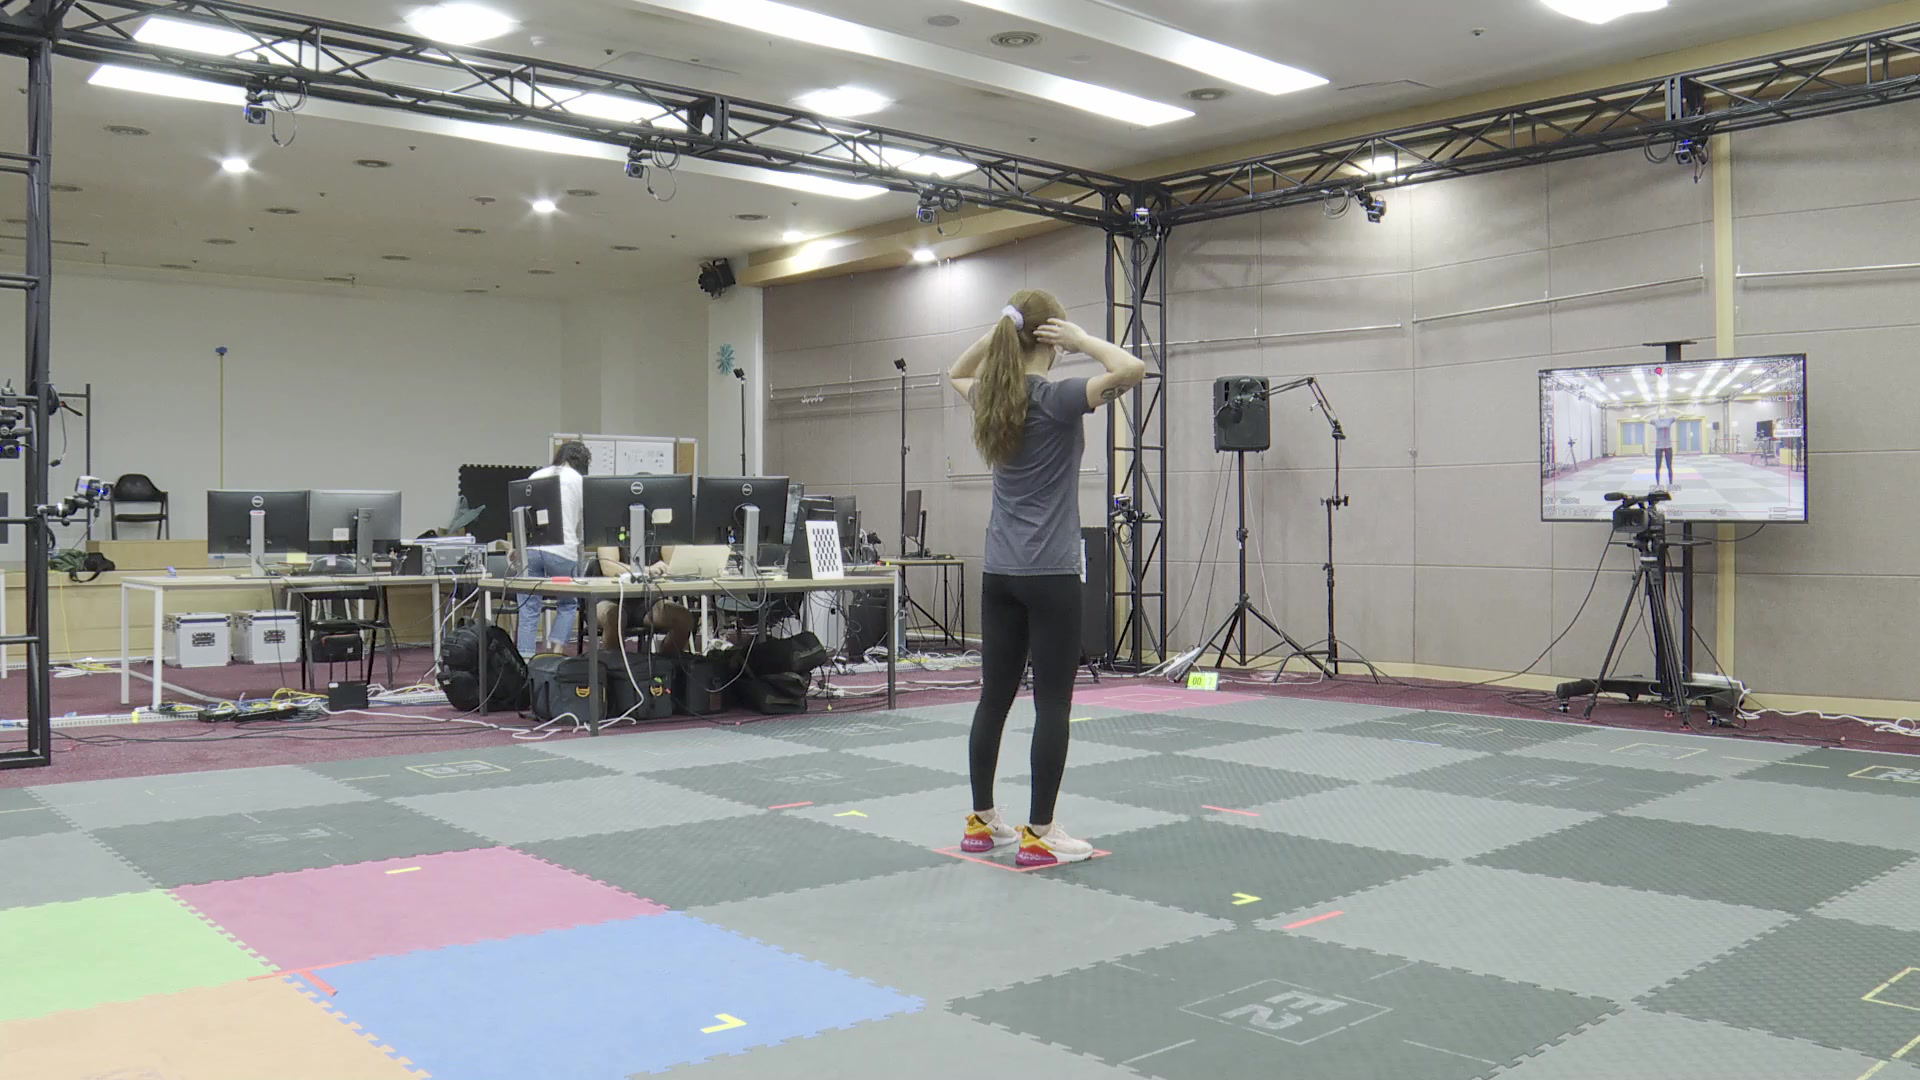

In [23]:
img_sample_path = train_paths[0]
img = Image.open(img_sample_path)
img_np = np.array(img)
img

In [24]:
img_np.shape

(1080, 1920, 3)

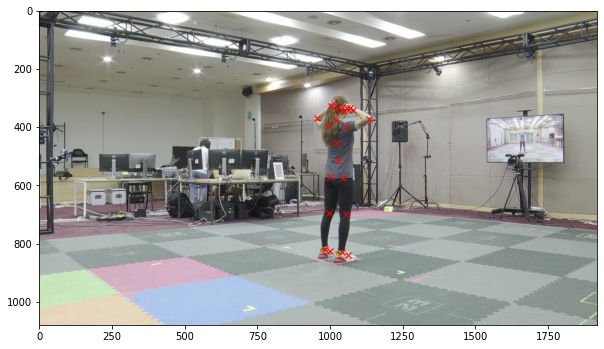

In [25]:
plt.figure(figsize = (10,10))
keypoint = train.iloc[:,1:49]
keypoint_sample = keypoint.iloc[0,:]

for j in range(0, len(keypoint.columns),2):
  plt.plot(keypoint_sample[j], keypoint_sample[j+1], 'rx')
  plt.imshow(img_np)

  

#Augmentation

##left_right_flip(좌우반전)

In [26]:
# Augmentation Setting
pixel_shifts = [12]
rotation_angles = [12]
inc_brightness_ratio = 1.2
dec_brightness_ratio = 0.8
noise_ratio = 0.008

In [27]:
# 좌우 반전
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=1)
    for idx, sample_keypoints in enumerate(keypoints):
        if idx%2 == 0:
            flipped_keypoints.append(480.-sample_keypoints)
        else:
            flipped_keypoints.append(sample_keypoints)
    
    # left_right_keypoints_convert
    for i in range(8):
        flipped_keypoints[2+(4*i):4+(4*i)], flipped_keypoints[4+(4*i):6+(4*i)] = flipped_keypoints[4+(4*i):6+(4*i)], flipped_keypoints[2+(4*i):4+(4*i)]
    flipped_keypoints[36:38], flipped_keypoints[38:40] = flipped_keypoints[38:40], flipped_keypoints[36:38]
    flipped_keypoints[44:46], flipped_keypoints[46:48] = flipped_keypoints[46:48], flipped_keypoints[44:46]
    
    return flipped_images, flipped_keypoints

In [28]:
img = tf.io.read_file(train['path'][0])
img = tf.image.decode_jpeg(img, channels = 3)
img = tf.image.resize(img, [270,480])
img = img / 255
target = train.iloc[:, 1:49].iloc[0, :]
target = target / 4
img, target = left_right_flip(img, target)

In [29]:
img.shape

TensorShape([270, 480, 3])

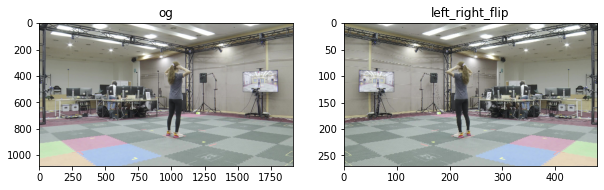

In [30]:
fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('og')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('left_right_flip')
ax1.imshow(img_np) # 원래 그림 
ax2.imshow(img) # 좌우반전 그림



##shift_images (수직/수평 동시 이동)

In [31]:
# 수직/수평 동시 이동
# forloop에서 shift_x, shift_y 중 하나만 놓으면
# 수직 또는 수평 이동만 따로 시행 가능
def shift_images(images, keypoints):
    # tensor -> numpy
    images = images.numpy()
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:   
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            # 이동할 matrix 생성
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            shifted_keypoint = np.array([])
            shifted_x_list = np.array([])
            shifted_y_list = np.array([])
            # 이미지 이동
            shifted_image = cv2.warpAffine(images, M, (480,270), flags=cv2.INTER_CUBIC)
            # 이동한만큼 keypoint 수정
            for idx, point in enumerate(keypoints):
                if idx%2 == 0: 
                    shifted_keypoint = np.append(shifted_keypoint, point+shift_x)
                    shifted_x_list = np.append(shifted_x_list, point+shift_x)
                else: 
                    shifted_keypoint =np.append(shifted_keypoint, point+shift_y)
                    shifted_y_list = np.append(shifted_y_list, point+shift_y)
            # 수정된 keypoint가 이미지 사이즈를 벗어나지 않으면 append
            if np.all(0.0<shifted_x_list) and np.all(shifted_x_list<480) and np.all(0.0<shifted_y_list) and np.all(shifted_y_list<270):
                shifted_images.append(shifted_image.reshape(270,480,3))
                shifted_keypoints.append(shifted_keypoint)

    return shifted_images, shifted_keypoints

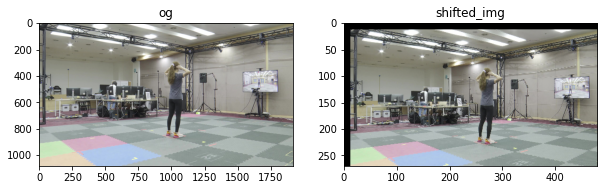

In [45]:
fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('og')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('shifted_img')
ax1.imshow(img_np) # 원래 그림 

img = tf.io.read_file(train['path'][0])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [270,480])
img = img/255
target = train.iloc[:,1:49].iloc[0,:]
target = target/4
img_list, target_list = shift_images(img, target)

for shifted_img, shifted_target in zip(img_list, target_list):
  ax2.imshow(shifted_img)

##이미지 회전

In [33]:
# 이미지 회전
def rotate_augmentation(images, keypoints):
    # tensor -> numpy
    images = images.numpy()
    rotated_images = []
    rotated_keypoints = []
    
    for angle in rotation_angles:
        for angle in [angle,-angle]:
            # 회전할 matrix 생성
            M = cv2.getRotationMatrix2D((240,135), angle, 1.0)
            # cv2_imshow로는 문제없지만 추후 plt.imshow로 사진을 확인할 경우 black screen 생성...
            # 혹시 몰라 matrix를 ndarray로 변환
            M = np.array(M, dtype=np.float32)
            angle_rad = -angle*pi/180
            rotated_image = cv2.warpAffine(images, M, (480,270))
            rotated_images.append(rotated_image)
            
            # keypoint를 copy하여 forloop상에서 값이 계속 없데이트 되는 것을 회피
            rotated_keypoint = keypoints.copy()
            rotated_keypoint[0::2] = rotated_keypoint[0::2] - 240
            rotated_keypoint[1::2] = rotated_keypoint[1::2] - 135
            
            for idx in range(0,len(rotated_keypoint),2):
                rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)

            rotated_keypoint[0::2] = rotated_keypoint[0::2] + 240
            rotated_keypoint[1::2] = rotated_keypoint[1::2] + 135
            rotated_keypoints.append(rotated_keypoint)
        
    return rotated_images, rotated_keypoints

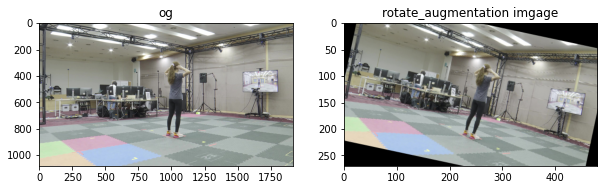

In [44]:
        fig = plt.figure(figsize = (10,20))
        ax1 = fig.add_subplot(1,2,1)
        ax1.set_title('og')
        ax2 = fig.add_subplot(1,2,2)
        ax2.set_title('rotate_augmentation imgage')
        ax1.imshow(img_np) # 원래 그림 
                
        
        img = tf.io.read_file(train['path'][0])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [270,480])
        img = img/255
        target = train.iloc[:,1:49].iloc[0,:]
        target = target/4
        img_list, target_list = rotate_augmentation(img, target)
        for rotated_img, rotated_target in zip(img_list, target_list):
          ax2.imshow(rotated_img)


##이미지 해상도 조절

In [37]:
# 이미지 해상도 조절
def alter_brightness(images):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*inc_brightness_ratio, 0.0, 1.0)
    dec_brightness_images = np.clip(images*dec_brightness_ratio, 0.0, 1.0)
    altered_brightness_images.append(inc_brightness_images)
    altered_brightness_images.append(dec_brightness_images)
    return altered_brightness_images

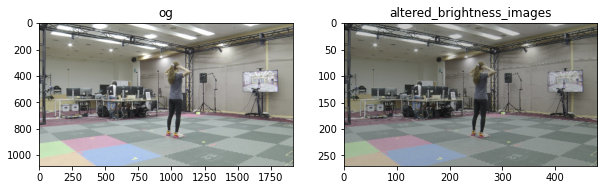

In [42]:
fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('og')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('altered_brightness_images')
ax1.imshow(img_np) # 원래 그림 



img = tf.io.read_file(train['path'][0])
img = tf.image.decode_jpeg(img, channels = 3)
img = tf.image.resize(img, [270,480])
img = img / 255
target = train.iloc[:, 1:49].iloc[0,:]
target = target / 4
img_list = alter_brightness(img)
for altered_brightness_images in img_list:
  ax2.imshow(altered_brightness_images) # 이미지 해상도 그림 

## adding_noise

In [46]:
# Random 노이즈 추가
def add_noise(images):
    images = images.numpy()
    noise = noise_ratio * np.random.randn(270,480,3)
    noise = noise.astype(np.float32)
    # 생성한 noise를 원본에 add
    noisy_image = cv2.add(images, noise)
    return noisy_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


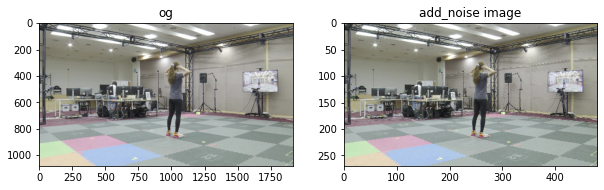

In [49]:
fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('og')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('add_noise image')
ax1.imshow(img_np) # 원래 그림 


img = tf.io.read_file(train['path'][0])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [270,480])
img = img/255
target = train.iloc[:,1:49].iloc[0,:]
target = target/4
noisy_img = add_noise(img)
ax2.imshow(noisy_img)